In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import rioxarray as rx
import numpy as np
import geopandas as gpd
from datetime import datetime
from datetime import timedelta

In [2]:
Rdrive = '/exports/csce/datastore/geos/users/s1332488/chapter2_data/'
uav_1ha = rx.open_rasterio(Rdrive+'UAV_canopy_disturbance_1ha.tif').sel(band=1).drop('band')
S1_deg = rx.open_rasterio(Rdrive+'S1_Airstrip_Degradation.tif').sel(band=1).drop('band')
ds = xr.merge([uav_1ha.rename('uav'),S1_deg.rename('S1')])
ds = ds.where(ds.uav >= 0.0)

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)

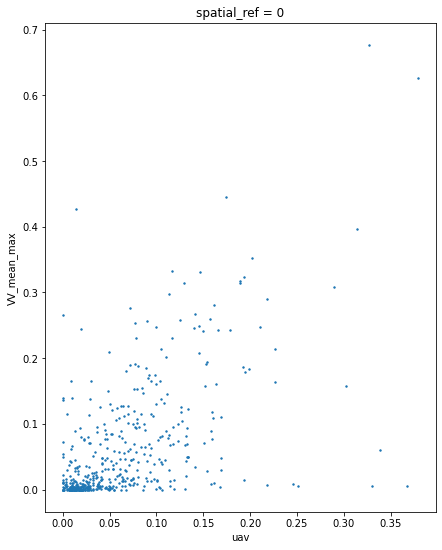

In [7]:
plt.figure(figsize=(7,9))
ds.plot.scatter(x='uav',y='S1',s=2)
from scipy import stats


reg = stats.linregress(ds.uav.values.flatten(), ds.S1.values.flatten())
reg

In [16]:
ds = xr.open_mfdataset('/disk/scratch/local.4/harry/S1/full_nc/S1_tile*_BS.nc',chunks={'lat':1000,'lon':1000})
ds

,Array,Chunk
Bytes,403.88 GiB,7.63 MiB
Shape,"(86, 22167, 28435)","(1, 1000, 1000)"
Count,114810 Tasks,57362 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,403.88 GiB,7.63 MiB
Shape,"(86, 22167, 28435)","(1, 1000, 1000)"
Count,114810 Tasks,57362 Chunks
Type,float64,numpy.ndarray


In [27]:
plt.figure(figsize=(12,3))
ds.isel(t=-1)

<xarray.Dataset>
Dimensions:  (lat: 22167, lon: 28435)
Coordinates:
    t        datetime64[ns] 2021-11-15
  * lat      (lat) float64 1.118 1.118 1.118 1.117 ... -0.8733 -0.8734 -0.8735
  * lon      (lon) float64 11.84 11.84 11.84 11.84 ... 14.39 14.39 14.39 14.39
Data variables:
    VH       (lat, lon) float64 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    VV       (lat, lon) float64 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    crs      int32 -2147483647
Attributes:
    Conventions:       CF-1.4
    TileSize:          616:632
    product_type:      GRD
    metadata_profile:  beam
    metadata_version:  0.5
    start_date:        06-JAN-2019 04:50:22.737321
    stop_date:         06-JAN-2019 04:50:47.736180
    title:             Sentinel-1 IW Level-1 GRD Product

<Figure size 864x216 with 0 Axes>

2019-01-05 00:00:00   UNTIL    2021-12-28 00:00:00


/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/matplotlib/colors.py:620: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


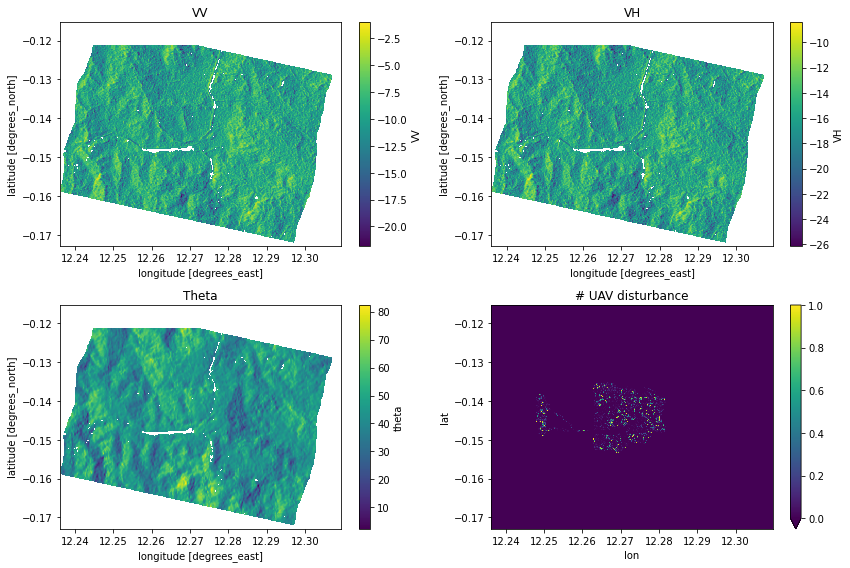

In [380]:
 # S-1 Backscatter Dataset
BS = xr.open_dataset('/disk/scratch/local.4/harry/S1/Ivindo_BS.nc')
#--------------------------------------------------------------------
# Sample points from Ivindo 
Rdrive = '/exports/csce/datastore/geos/users/s1332488/chapter2_data/'
logging_pts = gpd.read_file(Rdrive+'PTS/logging_jan20_points.shp') # Where logging took place 01/2020
disturbed = gpd.read_file(Rdrive+'PTS/uav_disturbance.shp') # Any disturbance in UAV data
ctrl_pts = gpd.read_file(Rdrive+'PTS/control_jan20_points.shp') # Any undisturbed points in UAV data
road = gpd.read_file(Rdrive+'PTS/road.shp') # Points along road built before 1st UAV collection
bare = gpd.read_file(Rdrive+'PTS/runway_pts.shp') # Points on the runway are bare ground
# And read in polygons for training and testing areas
training = gpd.read_file(Rdrive+'POLY/training.shp')
valid = gpd.read_file(Rdrive+'POLY/validation.shp')
#-------------------------------------------------------------------
# Read in target --> UAV canopy disturbance
uav = rx.open_rasterio(Rdrive+'UAV_canopy_disturbance.tif').rename({'x':'lon','y':'lat'}).sel(band=1).drop('band')
# Import Forest Cover Data (Sentinel 2020)
forest = rx.open_rasterio(Rdrive+'Ivindo_ForestCover.tif').rename({'x':'lon','y':'lat'}).sel(band=1).drop('band')

# Get rid of bits with uneven numbers of observations
BS = BS.where(BS.VV.count(dim='t') == BS.t.size)
# Get rid of NonForest Straight away
BS = BS.where(forest.interp_like(BS,method='linear') == 1) 

# Variable N is size of temporal kernel to be used
# Use this to select appropriate data for UAV time period
N = 30
start_date, end_date = datetime(2020,1,1), datetime(2021,1,1)
data_start = start_date - timedelta(days = 12*N + 1)
data_end = end_date + timedelta(days = 12*N + 1)
print(data_start,'  UNTIL   ',data_end)
BS = BS.sel(t=slice(data_start,data_end))

# Finally , a quick visualisation to check all OK with the data
plt.figure(figsize=(12,8))
ax1=plt.subplot(2,2,1); BS.VV.mean(dim='t').plot(); plt.title('VV')
plt.subplot(2,2,2); BS.VH.mean(dim='t').plot(); plt.title('VH')
plt.subplot(2,2,3); BS.theta.plot(); plt.title('Theta')
plt.subplot(2,2,4); uav.plot(vmin=0,vmax=1); plt.title('# UAV disturbance')
plt.tight_layout(); plt.show()

In [381]:
BS

<xarray.Dataset>
Dimensions:      (lat: 642, lon: 819, t: 87)
Coordinates:
  * t            (t) datetime64[ns] 2019-01-06 2019-01-18 ... 2021-11-15
  * lat          (lat) float64 -0.1153 -0.1154 -0.1155 ... -0.1728 -0.1729
  * lon          (lon) float64 12.24 12.24 12.24 12.24 ... 12.31 12.31 12.31
    spatial_ref  int64 0
Data variables:
    crs          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    VV           (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    VH           (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    theta        (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:       CF-1.4
    TileSize:          324:412
    product_type:      GRD
    metadata_profile:  beam
    metadata_version:  0.5
    start_date:        24-APR-2019 04:50:42.085412
    stop_date:         24-APR-2019 04:50:42.809764
    title:             Sentinel-1 IW Level-1 GRD Product

In [13]:
def view(ds,PTS):
    """
    Handy function for testing --> shows timeseries of data-array ds for "shapefiles in PTS"
    """
    plt.figure(figsize=(9,6))
    i=0
    colors=['red','blue','green','black']
    for P in PTS:
        for j in range(len(P)):
            ds.sel(lat=P.geometry[j].y,lon=P.geometry[j].x,method='nearest').plot(color=colors[i],alpha=.5)
        i+=1
    plt.show()
    
def view_scalar(ds,PTS):
    # Same again but for a scalar (i.e. single value for each pixel) ds
    plt.figure(figsize=(10,5))
    colors=['red','blue','green','black']
    i=0
    for P in PTS:
        for j in range(len(P)):
            #x=time_diff.sel(lat=disturbed.geometry[i].y,lon=disturbed.geometry[i].x,method='nearest')
            x=j
            y=ds.sel(lat=P.geometry[j].y,lon=P.geometry[j].x,method='nearest')
            plt.plot(x,y,'o',color=colors[i],alpha=0.3,markersize=15)
            plt.text(x,y,str(j))
        i+=1
    plt.show()

In [560]:
def convolve(band,N):
    """
    Takes either VV or VH band and performs convolutions to search for step decrease in backscatter
    N is the size of the kernel - larger is more reliable but requires more data
    Experiment suggests setting N to 30 is effective, 
    --> this means one year of data either side of the study period is required
    The length of the output is T - 2(N-1) if T is the original timeseries length
    Large values in the output indicate:
    --> A more clearly defined drop in backscatter with stable periods either side
    --> And/or a larger relative drop in backscatter 
    """
    kernel = xr.DataArray(np.concatenate([np.ones(N//2),-np.ones(N//2)]),dims=['kt'])
    conv1 = band.rolling(t=N,center=True).construct(t='kt').dot(kernel)
    relu = np.maximum(conv1, 0)
    triangle = np.concatenate([np.linspace(0,0.99,N//2),np.flip(np.linspace(0,0.99,N//2))])
    kernel2 = xr.DataArray(triangle,dims=['kt'])
    conv2 = relu.rolling(t=N,center=True).construct(t='kt').dot(kernel2)
    return conv2

def model(ds,N=30,NN=20):
    """
    model takes dataset ds (with non-forest masked already), containing VV and VH timeseries
    Timeseries should span a year on either side of the study period
    -- N (time kernel) is fixed to 30
    -- NN (spatial output size) is fixed to 20, i.e. 200m x 200m pixels are output
    -- C is a threshold parameter that is subtracted from the disturbance index
    -- M is scaling factor which multiplies the disturbance index
    outputs 
    """
    vv, vh = convolve(ds.VV,N), convolve(ds.VH,N)
    shadow = np.sqrt(vv*vh).max(dim='t')
    shadow = np.maximum(shadow-100,0) # Remove noise and set floor to zero 
    coarse = shadow.coarsen(lat=NN,lon=NN,boundary='trim').sum() / 335 # Calibrated with UAV data
    return coarse

In [561]:
# Run the model on our Sentinel-1 Dataset
S = model(BS)
S.rename({'lat':'y','lon':'x'}).rio.to_raster(Rdrive+'Ivindo_S1_disturbance.tif')

In [566]:
NN = 20 # size of pixel for UAV-S1 comparison (in 10m units)
# Format training data
s1_train = S.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
s1_train = s1_train.rio.write_crs('EPSG:4326')#.rio.clip(training.geometry)
uav_train = uav.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)#.rio.clip(training.geometry)

uav_train = uav_train.interp_like(s1_train,method='nearest').where(~S.isnull())
uav_train = uav_train.where(uav_train >=0 )
s1_train = s1_train.where(~uav_train.isnull())

uav_train_coarse = uav_train.coarsen(lat=NN,lon=NN,boundary='trim').sum()

def get_s1_coarse(p):
    M, C = 335,100
    denoise = np.maximum(s1_train-100,0)/335
    coarse = denoise.coarsen(lat=NN,lon=NN,boundary='trim').sum()
    return coarse
# Define a cost function to minimise
def cost_fn(p):
    coarse = get_s1_coarse(p)
    return ((coarse-uav_train_coarse)**2).sum().values

Text(0.5, 1.0, 'Canopy Loss (%)')

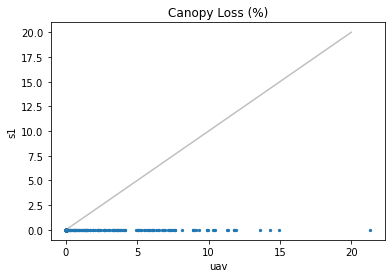

In [565]:
# from scipy.optimize import minimize
# result = minimize(cost_fn,[100,100])
# params = result.x
# print('Optimisation Success: ',result.success)
coarse = get_s1_coarse([335,100])
# print(params)
ds=xr.Dataset(data_vars={'s1':coarse,'uav':uav_train_coarse})
(100*ds/(NN**2)).plot.scatter(x='uav',y='s1',s=5)

l= 20
#plt.xlim(0,l); plt.ylim(0,l)
plt.plot([0,l],[0,l],color='grey',alpha=.5)
plt.title('Canopy Loss (%)')

#scipy.stats.linregress(x, y=None, alternative='two-sided')

LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=nan, intercept_stderr=nan)

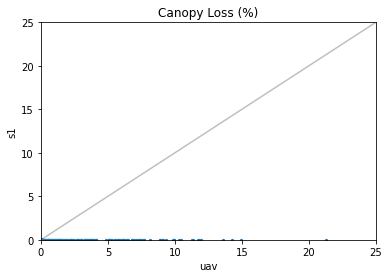

In [564]:
from scipy import stats
ds=(100/(NN**2))*xr.Dataset(data_vars={'s1':coarse,'uav':uav_train_coarse})
ds.plot.scatter(x='uav',y='s1',s=5)
l= 25
plt.xlim(0,l); plt.ylim(0,l)
plt.plot([0,l],[0,l],color='grey',alpha=.5)
plt.title('Canopy Loss (%)')

reg = stats.linregress(ds.uav.values.flatten(), ds.s1.values.flatten())
reg

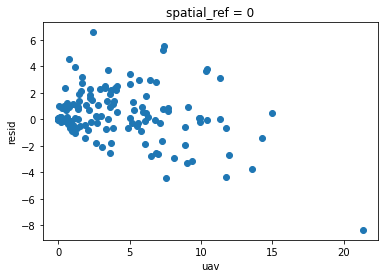

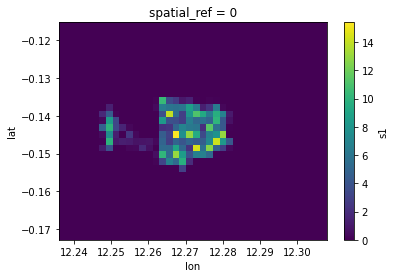

In [551]:
ds['resid']=(ds.s1 - ds.uav)

ds.plot.scatter(x='uav',y='resid')
plt.show()

ds.s1.plot()


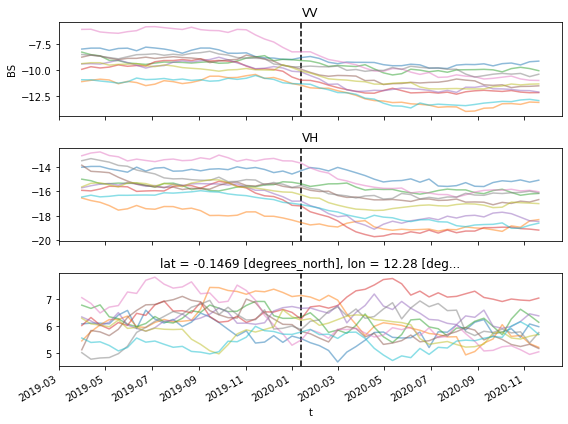

In [8]:
## Plot to see if pixels with known logging date show a discernible signal by eye

fig,axs = plt.subplots(3,1,figsize=(8,6),sharex=True)
with BS.drop('crs').rio.write_crs('EPSG:4326') as ds:
    for i in range(len(logging_pts)):
        point = ds.sel(lat=logging_pts.geometry[i].y,
                       lon=logging_pts.geometry[i].x,
                       method='nearest')
        #point.VV.sel(t=slice(datetime(2019,11,13),datetime(2020,3,13))).plot(color='grey',ax=axs[0],alpha=.5)
        #point.VH.sel(t=slice(datetime(2019,11,13),datetime(2020,3,13))).plot(color='green',ax=axs[1],alpha=.5)
        point.VV.rolling(t=15,center=True).mean().plot(ax=axs[0],alpha=.5)
        point.VH.rolling(t=15,center=True).mean().plot(ax=axs[1],alpha=.5)
        (point.VV.rolling(t=15,center=True).mean()-point.VH.rolling(t=15,center=True).mean()).plot(ax=axs[2],alpha=.5)
        #point.ratio.rolling(t=15,center=True).mean().plot(ax=axs[2],alpha=0.5)
#     for i in range(len(ctrl_pts)):
#         point = ds.sel(lat=ctrl_pts.geometry[i].y,
#                        lon=ctrl_pts.geometry[i].x,
#                        method='nearest')
#         point.coh_VV.isel(t=slice(None,8)).plot(color='grey',ax=axs[1,0],alpha=.5)
#         (point.coh_VH.isel(t=slice(None,8))-point.coh_VV.isel(t=slice(None,8))).plot(color='green',ax=axs[1,1],alpha=.5)
#BS.VV.mean(dim=['lat','lon']).rolling(t=15,center=True).mean().plot(ax=axs[2])
axs[0].axvline(x=datetime(2020,1,13),zorder=1,color='black',ls='--')
axs[1].axvline(x=datetime(2020,1,13),zorder=1,color='black',ls='--')
axs[2].axvline(x=datetime(2020,1,13),zorder=1,color='black',ls='--')
#axs[0].axhline(y=0,color='black',lw=0.2)
#axs[1].axhline(y=0,color='black',lw=0.2)
axs[0].set(title='VV',xlabel=None,ylabel='BS')
axs[1].set(title='VH',xlabel=None,ylabel=None)
plt.tight_layout()

plt.savefig('/home/s1332488/chapter2/logged_points_BS.png',dpi=300)